In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

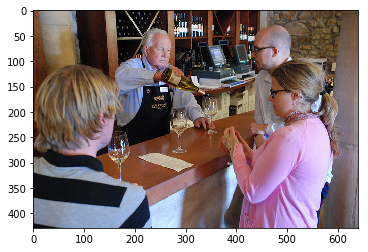

In [2]:
# Image taken from the MS-COCO dataset
test_img = mpimg.imread('test-image-1.jpg')
plt.imshow(test_img)

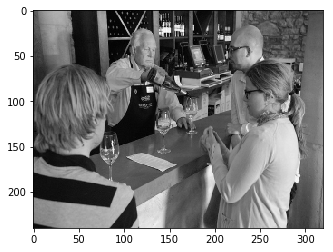

In [3]:
IMG_WIDTH = 320
IMG_HEIGHT = 240

# Step 1: Resize image to 320x240
resized_img = cv.resize(test_img, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(resized_img)

# Step 2: Convert to grayscale
gray_img = cv.cvtColor(resized_img, cv.COLOR_RGB2GRAY)
plt.imshow(gray_img, cmap='gray')

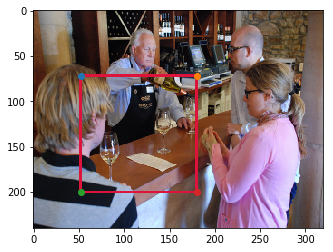

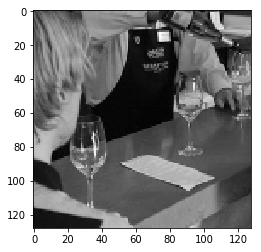

In [4]:
# Step 3: Randomly crop a square patch from the image
perturbation_max = 32
patch_size = 128

top_left_x = random.randint(perturbation_max, IMG_WIDTH - patch_size - perturbation_max)
top_left_y = random.randint(perturbation_max, IMG_HEIGHT - patch_size - perturbation_max)

top_left = [top_left_x, top_left_y]
top_right = [top_left[0] + patch_size, top_left[1]]
bottom_right = [top_left[0] + patch_size, top_left[1] + patch_size]
bottom_left = [top_left[0], top_left[1] + patch_size]

patch_orig = gray_img[top_left[1]:bottom_left[1], top_left[0]:top_right[0]]

# Display crop
resized_img_copy = resized_img.copy()

plt.scatter([top_left[0]], [top_left[1]])  # Blue
plt.scatter([top_right[0]], [top_right[1]])  # Orange
plt.scatter([bottom_left[0]], [bottom_left[1]])  # Green
plt.scatter([bottom_right[0]], [bottom_right[1]])  # Red

corners_square =[top_left, top_right, bottom_right, bottom_left]

cv.polylines(resized_img_copy, np.array([corners_square]), True, (220,20,60), 2)
plt.imshow(resized_img_copy)

plt.show()

plt.imshow(patch_orig, cmap='gray')
plt.show()

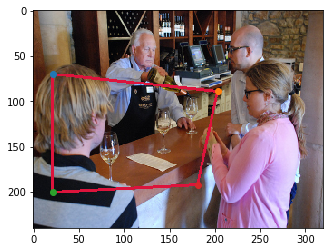

In [5]:
# Step 4: Perturb the square's corners
perturbed_corners = []

for corner in corners_square:
    # The +-1 in the random perturbations is to avoid generating a perturbation that will move the patch to
    # the border to prevent bordering artifacts later in the data generation pipeline
    new_x = corner[0] + random.randint(-perturbation_max+1, perturbation_max-1)
    new_y = corner[1] + random.randint(-perturbation_max+1, perturbation_max-1)
    perturbed_corners.append([new_x, new_y])
        
resized_img_copy = resized_img.copy()

perturbed_top_left = perturbed_corners[0]
perturbed_top_right = perturbed_corners[1]
perturbed_bottom_right = perturbed_corners[2]
perturbed_bottom_left = perturbed_corners[3]

plt.scatter([perturbed_top_left[0]], [perturbed_top_left[1]])  # Blue
plt.scatter([perturbed_top_right[0]], [perturbed_top_right[1]])  # Orange
plt.scatter([perturbed_bottom_left[0]], [perturbed_bottom_left[1]])  # Green
plt.scatter([perturbed_bottom_right[0]], [perturbed_bottom_right[1]])  # Red

perturbed_corners_square = [perturbed_top_left, perturbed_top_right, perturbed_bottom_right, perturbed_bottom_left]

cv.polylines(resized_img_copy, np.array([perturbed_corners_square]), True, (220,20,60), 2)
plt.imshow(resized_img_copy, cmap='gray')

plt.show()

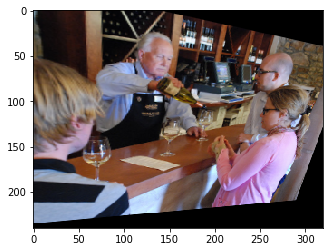

In [6]:
# Step 5: Calculate the homography H_ab
# See here for details: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
H_ab = cv.getPerspectiveTransform(np.float32(corners_square), np.float32(perturbed_corners))

warped_img = cv.warpPerspective(resized_img, H_ab, (IMG_WIDTH, IMG_HEIGHT))

plt.imshow(warped_img)

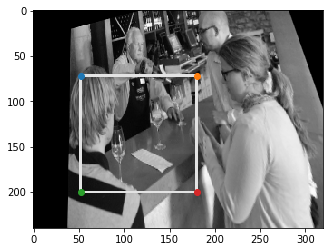

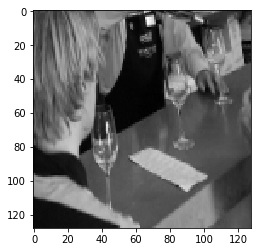

In [7]:
# Step 6: Calculate the inverse homoraphy H_ba
H_ba = np.linalg.inv(H_ab)

# Step 7: Create the new image I'
warped_img = cv.warpPerspective(gray_img, H_ba, (IMG_WIDTH, IMG_HEIGHT))

# Step 8: Crop second patch
warped_img_copy = warped_img.copy()

patch_warped = warped_img[top_left[1]:bottom_left[1], top_left[0]:top_right[0]]

plt.scatter([top_left[0]], [top_left[1]])  # Blue
plt.scatter([top_right[0]], [top_right[1]])  # Orange
plt.scatter([bottom_left[0]], [bottom_left[1]])  # Green
plt.scatter([bottom_right[0]], [bottom_right[1]])  # Red

cv.polylines(warped_img_copy, np.array([corners_square]), True, (220,20,60), 2)
plt.imshow(warped_img_copy, cmap='gray')

plt.show()

plt.imshow(patch_warped, cmap='gray')
plt.show()

In [8]:
# Step 9: Stack the patches together depth-wise
input = np.zeros((patch_size, patch_size, 2))
print(input.shape)
input[:, :, 0] = patch_orig
input[:, :, 1] = patch_warped

corners_square = np.array(corners_square)
perturbed_corners_square = np.array(perturbed_corners_square)

print(corners_square)
print(perturbed_corners_square)

# Step 10: calculate the difference between the corners of the perturbed patch and the original patch
# This is the target for the above training example
output = perturbed_corners_square - corners_square
print(output)

(128, 128, 2)
[[ 52  72]
 [180  72]
 [180 200]
 [ 52 200]]
[[ 21  70]
 [203  89]
 [181 192]
 [ 21 200]]
[[-31  -2]
 [ 23  17]
 [  1  -8]
 [-31   0]]
